In [ ]:
# generating data
import sys
import os
current_directory = os.getcwd()
sys.path.append(current_directory + '/../..')

from torch import nn
import torch
from optimisation.gen_data import getTicksForDay
from torch.utils.data import DataLoader, TensorDataset
from torch import optim


tick_data = []
for i in range(10000):
    _, ticks = getTicksForDay(i)
    tick_data.extend(ticks)

In [ ]:
# x[1], 

def create_dataset(dataset: list, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        # target = dataset[i + lookback][2]
        X.append([[x.tick, x.sell_price] for x in dataset[i:i+lookback]])
        y.append(dataset[i + lookback].sell_price)
    return torch.FloatTensor(X), torch.FloatTensor(y)


TRAIN_SIZE = 9000
train = tick_data[:TRAIN_SIZE]
test = tick_data[TRAIN_SIZE:]
lookback = 20

x_train, y_train = create_dataset(train, lookback)
x_test, y_test = create_dataset(test, lookback)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:

from matplotlib import pyplot as plt
from optimisation.price_model.price_lstm import PriceLSTM
from optimisation.utils import get_ema

input_size = x_train.shape[2]
model = PriceLSTM(input_size, lookback=lookback)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 1500
losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(get_ema(losses, 100), label='EMA Loss')
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Create a dataset for the single day
from optimisation.price_model.price_lstm import init_price_lstm

test_size = 200

_, ticks = getTicksForDay(1000)
start = 5000
vals = 100
tick_data = []
for i in range(start, start + vals):
    _, ticks = getTicksForDay(i)
    tick_data.extend(ticks)

x_test, y_test = create_dataset(tick_data[:vals], model.lookback)

# # Predict using the model
with torch.no_grad():
    y_test_pred = model(x_test).squeeze().numpy()
    loss = criterion(torch.tensor(y_test_pred), y_test)
    print(loss)

import matplotlib.pyplot as plt
from optimisation.utils import get_ema

plt.plot(y_test_pred[:vals], label='Predicted')
plt.plot(y_test[:vals], label='Actual')
plt.legend()
plt.show()

In [ ]:
# Create a dataset for the single day
# generating data
import sys
import os
current_directory = os.getcwd()
sys.path.append(current_directory + '/../..')

from optimisation.price_model.price_lstm import init_price_lstm
from optimisation.gen_data import getTicksForDay

test_size = 200
lookahead = 60
lookback = 20

model = init_price_lstm(input_size=2)
tick_data = []
for i in range(1000, 1010):
    _, ticks = getTicksForDay(i)
    tick_data.extend(ticks)


x_test, y_test = create_dataset(tick_data[0:], model.lookback)

input = x_test[0]
predictions = []
with torch.no_grad():
    for i in range(lookahead):
        y_pred = model(input.unsqueeze(0)).squeeze().numpy()
        # print(y_pred)
        predictions.append(y_pred.item())
        latest_tick = input[-1]
        next_tick = torch.tensor([latest_tick[0] + 1, y_pred], dtype=input.dtype)
        new_input = torch.cat((input[1:], next_tick.unsqueeze(0)), dim=0)
        input = new_input

print(len(predictions))
plt.plot(y_test[:lookahead], label='Actual')
plt.plot(predictions, label='Predicted (using auto-regression)')
plt.legend()
plt.show()

20


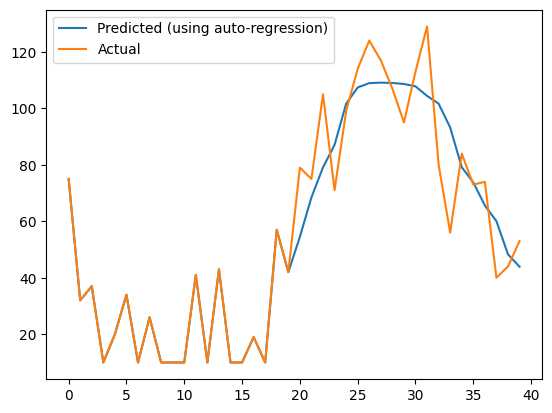

In [15]:
# Create a dataset for the single day
# generating data
from copy import deepcopy
import sys
import os
current_directory = os.getcwd()
sys.path.append(current_directory + '/../..')

from optimisation.price_model.price_lstm import init_price_lstm, create_input
from optimisation.gen_data import getTicksForDay
import torch
import matplotlib.pyplot as plt

test_size = 200
lookahead = 20

model = init_price_lstm(input_size=2)
tick_data = []
for i in range(1000, 1010):
    _, ticks = getTicksForDay(i)
    tick_data.extend(ticks)

def predict_future(model, ticks, lookahead):
    # Ticks should be of size 10

    predictions = []
    ticks = deepcopy(ticks[-model.lookback :])
    x_test = create_input(ticks, model.lookback)
    input = x_test[0]

    with torch.no_grad():
        for i in range(lookahead):
            y_pred = model(input.unsqueeze(0)).squeeze().numpy()
            predictions.append(y_pred.item())
            latest_tick = input[-1]
            next_tick = torch.tensor([latest_tick[0] + 1, y_pred], dtype=input.dtype)
            new_input = torch.cat((input[1:], next_tick.unsqueeze(0)), dim=0)
            input = new_input

    return predictions

start_index = 20
predictions = predict_future(model, tick_data[start_index: start_index + model.lookback], lookahead)
start = [x.sell_price for x in tick_data[start_index: start_index + model.lookback]]
overall = start + predictions
actual = [x.sell_price for x in tick_data[start_index: start_index + model.lookback + lookahead]]

print(len(predictions))
# plt.plot(y_test[:lookahead], label='Actual')
plt.plot(overall, label='Predicted (using auto-regression)')
plt.plot(actual, label='Actual')
plt.legend()
plt.show()